# Can we predict age from activation to complex emotional stimuli?

## Organize data

### Score Puberty data and combine with data labels

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

thresh=0.8

## load model data
project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/'
data_dir = project_dir + '/datasets/'
data_labels = pd.read_csv(data_dir + 'firstleveldatalabels_thresh{0}_20220412.csv'.format(thresh), index_col=0)
data_labels['sub'] = data_labels.index
data_labels.describe()

In [ ]:
## load puberty data
pub = pd.read_csv('/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/phenotypic_data/9994_PPS_20210322_nonans.csv', 
                  index_col='EID', header=0, skiprows=[1])
pub = pub.drop_duplicates()
pub = pub.dropna(how='all', subset=['PPS_M_01', 'PPS_M_02', 'PPS_M_03', 'PPS_M_04', 'PPS_M_05','PPS_F_01', 'PPS_F_02', 
                                    'PPS_F_03', 'PPS_F_04', 'PPS_F_06'])
pub.index = ['sub-{0}'.format(a) for a in pub.index]
pub.loc[pub['PPS_F_06']==1, 'PPS_F_06'] = 4
pub.loc[pub['PPS_F_06']==0, 'PPS_F_06'] = 1
pub['PPS_score'] = pub[['PPS_M_01', 'PPS_M_02', 'PPS_M_03', 'PPS_M_04', 'PPS_M_05', 
                        'PPS_F_01', 'PPS_F_02', 'PPS_F_03', 'PPS_F_04', 'PPS_F_06']].sum(skipna=True, axis=1)

# add puberty data to labels
data_labels = data_labels.merge(pub.loc[:,['PPS_score']], how='left', left_index=True, right_index=True)
data_labels = data_labels.drop_duplicates()
data_labels.to_csv(data_dir + 'firstleveldatalabels_withpub_thresh{0}_20220412.csv'.format(thresh))
data_labels.describe()

In [ ]:
# plot age versus puberty
age_pub = data_labels.loc[:,['PPS_score','age','female']].drop_duplicates()
n, bins, patches = plt.hist(age_pub.PPS_score, bins=15, align='mid')
plt.show()
plt.close()
plt.figure()
sns.scatterplot(x='age',y='PPS_score', data=age_pub, hue='female')
plt.show()
plt.close()

## Set up class for analysis

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
from sklearn.svm import SVC, SVR
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold, permutation_test_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import itertools
import random

today = date.today().strftime('%Y%m%d')

In [2]:
def cv_fit(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']

    for i, a in enumerate(results['estimator']):
        c = np.expand_dims(a.coef_, axis=2)
        if i==0:
            weights = c
        else:
            weights = np.concatenate([weights, c], axis=2)
    
    estimators = results['estimator']
    weights = np.absolute(weights)
    mean_weights = np.mean(np.mean(weights, axis=2), axis=0, keepdims=True)
    return(estimators, weights, mean_weights, Y_pred, train_scores)

def cv_fit_poly(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
        
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']
    estimators = results['estimator']
    return(estimators, Y_pred, train_scores)


def bootstrap_train_score(model, X, Y, groups, cv, outdir, kind='classifier', ci=90, samples=10000):
    
    # determine percentiles for the CI estimation from the bootstrapped distribution
    lower = (100 - ci)/2
    upper = 100 - lower

    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'

    train_scores = []
    corrcoeffs = []

    for a in range(0,samples):
        bootsample_size = random.randint(int(len(Y)*0.5),int(len(Y)*0.75))
        subsampmask = np.full(len(Y), 0)
        subsampmask[:bootsample_size] = 1
        np.random.shuffle(subsampmask)
        X_temp = X[subsampmask==1,:]
        Y_temp = Y[subsampmask==1]
        g_temp = groups[subsampmask==1]
        results = cross_validate(model, X=X_temp, y=Y_temp, groups=g_temp, n_jobs=10,
                                 cv=cv, return_estimator=False, scoring=scoring)
        train_scores.append(results['test_score'])

        if kind=='regress':
            Y_t = cross_val_predict(model, X=X_temp, y=Y_temp, groups=g_temp, n_jobs=10, cv=cv)
            r, p = scp.spearmanr(Y_temp, Y_t)
            corrcoeffs.append(r)

    # test if boot strapped distibution is normally distributed
    train_scores = np.concatenate(train_scores).flatten()
    k , p = scp.kstest(train_scores, 'norm')        

    # store and save results
    results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
    results.loc['train_scores','boot_mean'] = np.mean(train_scores)
    results.loc['train_scores','boot_SD'] = np.std(train_scores)
    results.loc['train_scores','boot_median'] = np.percentile(train_scores, 50)
    results.loc['train_scores','CI'] = ci
    results.loc['train_scores','lowerCI'] = np.percentile(train_scores, lower)
    results.loc['train_scores','upperCI'] = np.percentile(train_scores, upper)
    results.loc['train_scores','KSstat'] = k
    results.loc['train_scores','KSpval'] = p

    if kind=='regress':
        k , p = scp.kstest(corrcoeffs, 'norm')
        corrcoeffs = np.array(corrcoeffs)

        results.loc['pearsonr','boot_mean'] = np.mean(corrcoeffs)
        results.loc['pearsonr','boot_SD'] = np.std(corrcoeffs)
        results.loc['pearsonr','boot_median'] = np.percentile(corrcoeffs, 50)
        results.loc['pearsonr','CI'] = ci
        results.loc['pearsonr','lowerCI'] = np.percentile(corrcoeffs, lower)
        results.loc['pearsonr','upperCI'] = np.percentile(corrcoeffs, upper)
        results.loc['pearsonr','KSstat'] = k
        results.loc['pearsonr','KSpval'] = p

    results.to_csv(os.path.join(outdir, 'bootstrapped_training_accuracy_randN.csv'))

    return(results)


def predict_out(X, Y, estimators, kind):
    index = range(0,len(Y))
    for i, a in enumerate(estimators):
        if i==0:
            Y_pred = a.predict(X)
            Y_test = Y
            ind = index
        else:
            Y_pred = np.concatenate([Y_pred, a.predict(X)], axis=0)
            Y_test = np.concatenate([Y_test, Y], axis=0)
            ind = np.concatenate([ind, index], axis=0)

    if kind=='classifier':
        accuracy = pd.DataFrame.from_dict(classification_report(Y_test, Y_pred, output_dict=True)).T
    elif kind=='regress':
        var_series = pd.Series(Y_pred, index=ind)
        var_series = var_series.groupby(var_series.index).mean()
        accuracy = pd.DataFrame(columns = ['stat','pval'])
        Y_test = Y
        Y_pred = var_series.to_numpy()
        accuracy.loc['SpearmanR','stat'], accuracy.loc['SpearmanR','pval'] = scp.spearmanr(Y_pred, Y_test)
        accuracy.loc['PearsonR','stat'], accuracy.loc['PearsonR','pval'] = scp.pearsonr(Y_pred, Y_test)
        slope, intercept, r, p, se = scp.linregress(Y_pred, Y_test)
        accuracy.loc['LinearB','stat'] = slope
        accuracy.loc['LinearB','pval'] = p
        accuracy.loc['MSE','stat'] = mean_squared_error(Y_pred, Y_test)
    return(Y_pred, accuracy)


def boot_predict(estimators, X, Y, outdir, kind='classifier', ci=90, samples=10000):
    # determine percentiles for the CI estimation from the bootstrapped distribution
    lower = (100 - ci)/2
    upper = 100 - lower

    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'

    test_scores = []
    pearsonr = []
    spearmanr = []

    for a in range(0,samples):
        bootsample_size = random.randint(int(len(Y)*0.5),int(len(Y)*0.75))
        subsampmask = np.full(len(Y), 0)
        subsampmask[:bootsample_size] = 1
        np.random.shuffle(subsampmask)
        X_temp = X[subsampmask==1,:]
        Y_temp = Y[subsampmask==1]

        for a in estimators:
            Y_pred = a.predict(X_temp)
            if kind=='classifier':
                t = classification_report(Y_temp, Y_pred, output_dict=True)
                test_scores.append(t['accuracy'])
            elif kind=='regress':
                mse = mean_squared_error(Y_temp, Y_pred)
                r, p = scp.spearmanr(Y_temp, Y_pred)
                test_scores.append(mse)
                spearmanr.append(r)
                r, p = scp.pearsonr(Y_temp, Y_pred)
                pearsonr.append(r)

    # test if boot strapped distibution is normally distributed
    test_scores = np.array(test_scores)
    k , p = scp.kstest(test_scores, 'norm')        

    # store and save results
    results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
    results.loc['test_scores','boot_mean'] = np.mean(test_scores)
    results.loc['test_scores','boot_SD'] = np.std(test_scores)
    results.loc['test_scores','boot_median'] = np.percentile(test_scores, 50)
    results.loc['test_scores','CI'] = ci
    results.loc['test_scores','lowerCI'] = np.percentile(test_scores, lower)
    results.loc['test_scores','upperCI'] = np.percentile(test_scores, upper)
    results.loc['test_scores','KSstat'] = k
    results.loc['test_scores','KSpval'] = p

    if kind=='regress':
        k , p = scp.kstest(spearmanr, 'norm')
        spearmanr = np.array(spearmanr)

        results.loc['spearmanr','boot_mean'] = np.mean(spearmanr)
        results.loc['spearmanr','boot_SD'] = np.std(spearmanr)
        results.loc['spearmanr','boot_median'] = np.percentile(spearmanr, 50)
        results.loc['spearmanr','CI'] = ci
        results.loc['spearmanr','lowerCI'] = np.percentile(spearmanr, lower)
        results.loc['spearmanr','upperCI'] = np.percentile(spearmanr, upper)
        results.loc['spearmanr','KSstat'] = k
        results.loc['spearmanr','KSpval'] = p

        k , p = scp.kstest(pearsonr, 'norm')
        pearsonr = np.array(pearsonr)

        results.loc['pearsonr','boot_mean'] = np.mean(pearsonr)
        results.loc['pearsonr','boot_SD'] = np.std(pearsonr)
        results.loc['pearsonr','boot_median'] = np.percentile(pearsonr, 50)
        results.loc['pearsonr','CI'] = ci
        results.loc['pearsonr','lowerCI'] = np.percentile(pearsonr, lower)
        results.loc['pearsonr','upperCI'] = np.percentile(pearsonr, upper)
        results.loc['pearsonr','KSstat'] = k
        results.loc['pearsonr','KSpval'] = p

    results.to_csv(os.path.join(outdir, 'bootstrapped_test_accuracy_randN.csv'))
    return(results)


def make_confusion_matrix(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)

    if Y.shape[0] == Y_pred.shape[0]:
        fig = ConfusionMatrixDisplay.from_predictions(Y, Y_pred)
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
    else:
        print("ERROR: length mismatch")    

def make_consistency_plot(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)
            
    if Y.shape[0] == Y_pred.shape[0]:
        plt.figure(figsize=(4,3))
        plt.scatter(Y, Y_pred)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.tight_layout()
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
        plt.show()
        plt.close()
    else:
        print("ERROR: length mismatch")    
        
def make_cifti_weights(weights, mean_weights, sample_file, out_prefix):
    if weights.ndim==3:
        weights = np.mean(weights, axis=2)
    
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,1,weights.shape[0], unit='second')
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(weights, (ax0, ax1))
    nib.save( weights_img, '{0}_SVM_weights_{1}.ptseries.nii'.format(out_prefix,today))

    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(np.mean(mean_weights, axis=0), axis=0), (ax0, ax1))
    nib.save( weights_img, '{0}_SVC_weights_mean_{1}.pscalar.nii'.format(out_prefix, today))

def create_mean_act_files(X_train, Y_train, X_test, Y_test, sample_file, weights, out_folder, kind):
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)

    if kind=='classifier':
        weight_table = pd.DataFrame(index=ax1.name)
        weight_table['mean_weight'] = np.squeeze(weights)
        train_activation = pd.DataFrame(X_train, columns = ax1.name, index=[a+'_train' for a in Y_train])
        test_activation = pd.DataFrame(X_test, columns = ax1.name, index=[a+'_test' for a in Y_test])
        activation = pd.concat(train_activation, test_activation)
        mean_act = activation.groupby(activation.index.name).mean()
        weight_table[mean_act.index] = mean_act.T
        weight_table.to_csv('{0}weights_activation_table_{1}.csv'.format(out_folder, today))
        for a in mean_act.index:
            img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(mean_act.loc[a,:], axis=0), (ax0, ax1))
            nib.save(img, '{0}mean_activation_{1}_{2}.pscalar.nii'.format(out_folder, a, today))

    elif kind=='regress':
        pearson = np.zeros((1, ax1.name.shape[0]))
        for a in range(0,pearson.shape[1]):
            r, p = scp.stats.pearsonr(X_train[:,a],Y_train)
            pearson[:,a] = r
        img = nib.cifti2.cifti2.Cifti2Image(pearson, (ax0, ax1))
        nib.save(img, '{0}activation_train_pearsonr_{1}.pscalar.nii'.format(out_folder, today))
        pearson = np.zeros((1, ax1.name.shape[0]))
        for a in range(0,pearson.shape[1]):
            r, p = scp.stats.pearsonr(X_test[:,a],Y_test)
            pearson[:,a] = r
        img = nib.cifti2.cifti2.Cifti2Image(pearson, (ax0, ax1))
        nib.save(img, '{0}activation_test_pearsonr_{1}.pscalar.nii'.format(out_folder, today))

def permuted_p(model, X, Y, cv, groups, out_folder, train_score, test_score, n_perms=1000):

    # Perform permutation testing to get a p-value
    if isinstance(model, SVC):
        scoring = 'accuracy'

        train_score, permutation_scores, pvalue = permutation_test_score(model, X, Y, scoring=scoring, 
                                                                         cv=cv, n_permutations=n_perms, n_jobs=10, groups=groups)
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
        if isinstance(Y, pd.Series):
            Y = Y.to_numpy()

        Y_shuff = Y
        scores = np.zeros((n_perms, cv.n_splits))
        for a in range(0,n_perms):
            np.random.shuffle(Y_shuff)
            res = cross_validate(model, X=X, y=Y_shuff, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            scores[a,:] = res['test_score']

        permutation_scores = scores.flatten()

    # Save a figure of the permutation scores
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(permutation_scores, 20, label='Permutation scores', density=True)
    ax.axvline(train_score, ls='-', color='m', label='Train')
    ax.axvline(test_score, ls='--', color='g', label='Test')
    if isinstance(model, SVC):
        ax.axvline(1. / len(Y_train.unique()), ls='--', color='k', label='Chance')   
    plt.legend()
    plt.xlabel('Score')
    plt.tight_layout()
    plt.savefig('{0}permutation_plot_{1}.svg'.format(out_folder, today), transparent=True)
    plt.close()

    # Save scores as a csv
    results = pd.DataFrame()
    results.loc['Train_Score','Stat'] = train_score
    results.loc['Test_Score','Stat'] = test_score
    results.loc['Train_Score','PermPval'] = (np.sum((permutation_scores>=train_score).astype(int)) + 1) / (n_perms*cv.n_splits + 1)
    results.loc['Test_Score','PermPval'] = (np.sum((permutation_scores>=test_score).astype(int)) + 1) / (n_perms*cv.n_splits + 1)
    results.to_csv('{0}permutation_stats.csv'.format(out_folder))
    return(results, permutation_scores)

def permuted_importance(estimators_list, X, Y, sample_file, out_folder):
    results = []
    if isinstance(estimators_list[0], SVC):
        scoring = 'accuracy'
    elif isinstance(estimators_list[0], SVR):
        scoring = 'neg_mean_squared_error'
    
    for a in estimators_list:
        r = permutation_importance(a, X, Y, scoring=scoring, n_repeats=100, n_jobs=10, random_state=42)
        results.append(r)

    for i, r in enumerate(results):
        if i==0:
            imp_scores = r['importances'].T
        else:
            imp_scores = np.concatenate([imp_scores, r['importances'].T], axis=0)
    
    # save CIFTI with mean importance scores
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    impciftidata = np.expanddims(np.mean(imp_scores, axis=1), axis=0)
    img = nib.cifti2.cifti2.Cifti2Image(impciftidata, (ax0, ax1))
    nib.save(img, '{0}mean_permuted_importance_scores_{1}.pscalar.nii'.format(out_folder, today))
    
    # save dataframe with all the scores
    imp_score_table = pd.DataFrame(imp_scores.T, index=ax1.name)
    imp_score_table.to_csv('{0}permuted_importance_scores_{1}.csv'.format(out_folder, today))
    
    # save dataframe with mean scores
    imp_mean=np.mean(imp_scores, axis=0, keepdims=True)
    imp_table = pd.DataFrame(index=ax1.name)
    imp_table['mean_importance'] = np.squeeze(imp_mean)
    imp_table.to_csv('{0}mean_importance_{1}.csv'.format(out_folder, today))

    # plot importance scores
    imp_table['region'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='region', data=sorted_imp_table.iloc[:20,:], ci=None, color="#3B75AF")
    plt.xlabel('Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}top20importance_{1}.svg'.format(out_folder, today))
    
def permuted_network_importance(model, X, Y, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<=2:
            network_labels.append('Subcortical')
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    model_score = np.mean(model_score)

    for i in range(0,n_perms):
        for net in network_names:
            # permute only the network-specific features
            net_perm_X = np.load(out_folder + 'temp.npy')
            netperm = net_perm_X[:,network_labels==net]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X[:,network_labels==net] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc[net,i] = perm_imp

        for n, count in enumerate(network_sizes):
            mask = np.full(X.shape[1], 0)
            mask[:count] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc[network_names[n],i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    imp_table['network'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='network', data=sorted_imp_table, ci=None, color="#3B75AF")
    plt.xlabel('Mean Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}network_importance_{1}.svg'.format(out_folder, today))

    imp_table = perm_netrand_imp.mean(axis=1).to_frame(name='mean_importance')
    imp_table['random_network'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='random_network', data=sorted_imp_table, ci=None, color="#3B75AF")
    plt.xlabel('Mean Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}random_networksize_importance_{1}.svg'.format(out_folder, today))
    return(perm_net_imp, perm_netrand_imp)
    
def permuted_N_networks_importance(model, X, Y, N, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<=2:
            network_labels.append('Subcortical')
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(columns=range(0,n_perms))
    model_score = np.mean(model_score)
    combs = itertools.combinations(network_names, N)

    for nets in combs:
        for i in range(0,n_perms):
            # permute only the network-specific features
            net_perm_X = pd.DataFrame(np.load(out_folder + 'temp.npy'), columns=network_labels)
            netperm = net_perm_X.loc[:,nets]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X.loc[:,nets] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=15, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc['{0}'.format(nets),i] = perm_imp

            mask = np.full(X.shape[1], 0)
            mask[:netperm.shape[1]] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=15, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc['{0}'.format(nets),i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    
    # Reorder the networks by mean permuted importance
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    neworder = sorted_imp_table.index

    # reorder dataframes and drop to only top 20 means
    perm_netrand_imp_reord = perm_netrand_imp.reindex(neworder).iloc[:20,:]
    perm_net_imp_reord = perm_net_imp.reindex(neworder).iloc[:20,:]

    # convert to long format
    idvars = perm_netrand_imp_reord.columns
    perm_netrand_imp_reord['networks'] = perm_netrand_imp_reord.index
    temp_randperm = pd.melt(perm_netrand_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    idvars = perm_net_imp.columns
    perm_net_imp_reord['networks'] = perm_net_imp_reord.index
    temp_perm = pd.melt(perm_net_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    # Initialize figure
    f, ax = plt.subplots(figsize=(7, 7))

    # Plot the actual permuted values
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_perm, 
                  color='#9370DB', showfliers=False)

    # Plot the null distributions
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_randperm,
                   color='darkgray', showfliers=False)

    # Tweak the visual presentation and save
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}perm_N{1}_importance_{2}.svg'.format(out_folder, N, today))
    
    return(perm_net_imp, perm_netrand_imp)

In [3]:
## make class to handle model fitting
class permutedSVM:
    def __init__(self, model, cv, output_folder, folds=10, perm_iters=1000):
        self.cv = cv
        self.folds = folds
        self.perm_iters = perm_iters
        self.outfolder = output_folder
        self.random_state = model.random_state
        self.parcel_labels = None
        self.network_labels = None
        self.groups = None
        self.X_train = None
        self.Y_train = None
        self.bootstrap_train = None
        self.X_test = None
        self.Y_test = None
        self.boostrap_test = None
        self.model = model
        self.estimators = None
        self.weights = None
        self.mean_weights = None
        self.Y_test_pred = None
        self.Y_train_pred = None
        self.test_score = None
        self.template_outfile = None
        self.perm_pval = None
        self.perm_scores = None
        self.train_scores = None
        self.net_perms = None
        self.net_null_perms = None
        self.N_net_perms = None
        self.N_net_null_perms = None
        
        os.makedirs(output_folder, exist_ok=True)

    def fit(self, X_train, Y_train, groups, kernel='linear'):
        self.X_train = X_train
        self.Y_train = Y_train
        self.groups = groups 
        if kernel=='linear':
            estimators, weights, mean_weights, Y_pred, train_scores = cv_fit(self.model, self.X_train, self.Y_train, self.groups, self.cv)
            self.estimators = estimators
            self.weights = weights
            self.mean_weights = mean_weights
            self.Y_train_pred = Y_pred
            self.train_scores = train_scores
        elif kernel=='poly':
            estimators, Y_pred, train_scores = cv_fit_poly(self.model, self.X_train, self.Y_train, self.groups, self.cv)
            self.estimators = estimators
            self.Y_train_pred = Y_pred
            self.train_scores = train_scores
            
        with open(os.path.join(self.outfolder,'insample_accuracy.txt'), 'w') as f:
            f.write(str(np.mean(self.train_scores)))
        return(self)
    
    def boot_fit(self, kind='classifier', ci=90, boot_samples=10000):
        results = bootstrap_train_score(self.model, self.X_train, self.Y_train, self.groups, self.cv, self.outfolder, 
                                        kind=kind, ci=ci, samples=boot_samples)
        self.bootstrap_train = results
        return(self)
    
    def predict(self, X_test, Y_test, kind='classifier'):
        self.X_test = X_test
        self.Y_test = Y_test
        Y_pred, accuracy = predict_out(self.X_test, self.Y_test, self.estimators, kind=kind)
        self.Y_test_pred = Y_pred
        self.test_score = accuracy
        accuracy.to_csv(self.outfolder + 'performance_report.csv')
        return(self)
    
    def boot_predict(self, kind='classifier', ci=90, boot_samples=10000):
        results = boot_predict(self.estimators, self.X_test, self.Y_test, self.outfolder, kind=kind, ci=ci, samples=boot_samples)
        self.bootstrap_test = results
        return(self)

    def plot_confusion(self, outfile_name='confusion_matrix'):
        make_confusion_matrix(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_consistency(self, outfile_name='consistency_plot'):
        make_consistency_plot(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_weights(self, template_outfile, out_prefix='model'):
        self.template_outfile = template_outfile
        make_cifti_weights(self.weights, self.mean_weights, self.template_outfile, self.outfolder + out_prefix)
        
    def make_weights_table_img(self, kind='classifier'):
        create_mean_act_files(self.X_train, self.Y_train, self.X_test, self.Y_test, self.template_outfile, self.mean_weights, self.outfolder, kind)
        
    def calc_permuted_pvalue(self, kind='classifier'):
        if kind=='classifier':
            test_acc = self.test_score.loc['accuracy','precision']
            train_acc = np.mean(self.train_scores)
        elif kind=='regress':
            test_acc = -svc.test_score.loc['MSE','stat']
            train_acc = np.mean(self.train_scores)
        pvalue, permutation_scores = permuted_p(self.model, self.X_train, self.Y_train, self.cv, self.groups, self.outfolder, train_acc, test_acc, n_perms=self.perm_iters)
        self.perm_pval = pvalue
        self.perm_scores = permutation_scores
        np.save(self.outfolder + 'permutation_scores.npy', permutation_scores)
        return(self)
    
    def get_perm_importance(self):
        permuted_importance(self.estimators, self.X_train, self.Y_train, self.template_outfile, self.outfolder)
        
    def get_perm_net_importance(self, n_perms=500):
        perm_net_imp, perm_netrand_imp = permuted_network_importance(self.model, self.X_train, self.Y_train, self.template_outfile, self.outfolder, self.train_scores, n_perms)
        self.net_perms = perm_net_imp
        perm_net_imp.to_csv(self.outfolder+'perm_N1_net_imp.csv')
        self.net_null_perms = perm_netrand_imp
        perm_netrand_imp.to_csv(self.outfolder+'perm_N1_randnet_imp.csv')
        return(self)
        
    def get_perm_N_net_importance(self, N, n_perms=500):
        perm_net_imp, perm_netrand_imp = permuted_N_networks_importance(self.model, self.X_train, self.Y_train, N, self.template_outfile, self.outfolder, self.train_scores, n_perms)
        self.N_net_perms = perm_net_imp
        perm_net_imp.to_csv(self.outfolder+'perm_N{0}_net_imp.csv'.format(N))
        self.N_net_null_perms = perm_netrand_imp
        perm_netrand_imp.to_csv(self.outfolder+'perm_N{0}_randnet_imp.csv'.format(N))
        return(self)
    
    
    def full_pipeline(self, X_train, Y_train, groups, X_test, Y_test, template_outfile, kernel='linear', kind='classifier'):
        self.groups = groups
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.template_outfile = template_outfile

        self.fit(X_train, Y_train, groups, kernel=kernel)
        self.predict(X_test, Y_test, kind=kind)
        self.plot_consistency()
        self.boot_fit(kind=kind, ci=95)
        self.boot_predict(kind=kind, ci=95)
        self.make_weights_table_img(kind=kind)
        self.calc_permuted_pvalue(kind='regress')
        self.get_perm_importance()
        self.get_perm_net_importance(n_perms=1000)
        return(self)

## load data

In [12]:
thresh=0.8

## load model data
project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/'
data_dir = project_dir + 'datasets/'
out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/linear/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)
sample_file = project_dir + 'datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
data = np.load(data_dir + 'firstleveldata_thresh{0}_20220412.npy'.format(thresh))
data_labels = pd.read_csv(data_dir + 'firstleveldatalabels_withpub_thresh{0}_20220412.csv'.format(thresh), index_col=None)

# get network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

## Analysis 1-1: SVR predicting age from activation - linear Kernel

### Set model parameters

In [5]:
## model parameters
folds = 10
cv = GroupKFold(n_splits=folds)
random_state = 42
model = SVR(kernel='linear')

out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/linear/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)

# split training and testing data by site
full_train = data[data_labels['site']=='rubic']
full_train_labels = data_labels[data_labels['site']=='rubic']
full_test = data[data_labels['site']=='cbic']
full_test_labels = data_labels[data_labels['site']=='cbic']

### Main analysis: predict from emo activation

In [ ]:
# include all data from both movies.
dataset = 'emo'

for emo in ['positive','negative']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
    out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.plot_weights(sample_file)
    svc.make_weights_table_img(kind='regress')
    svc.boot_predict(kind='regress',ci=95)
    svc.calc_permuted_pvalue(kind='regress')
    svc.plot_consistency()
    
for emo in ['anger','happy','fear','excite','sad']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
    out_folder = out_dir+'specific_data-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.plot_weights(sample_file)
    svc.make_weights_table_img(kind='regress')
    svc.boot_predict(kind='regress',ci=95)
    svc.calc_permuted_pvalue(kind='regress')
    svc.plot_consistency()

In [9]:
# include all data from both movies and test if a single network is sufficient.
dataset = 'emo'

for net in network_names:

    for emo in ['positive','negative']:
        #set specific variables
        X_train = full_train[full_train_labels['cond']==emo][:,network_labels==net]
        Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:,network_labels==net]
        Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
        out_folder = out_dir+'general_data-{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        #svc.plot_consistency()
        if not os.path.isfile(os.path.join(out_folder, 'bootstrapped_test_accuracy_randN.csv')):
            svc.boot_predict(kind='regress',ci=95)

    for emo in ['anger','happy','fear','excite','sad']:
        #set specific variables
        X_train = full_train[full_train_labels['cond']==emo][:,network_labels==net]
        Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:,network_labels==net]
        Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
        out_folder = out_dir+'specific_data-{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        #svc.plot_consistency()
        if not os.path.isfile(os.path.join(out_folder, 'bootstrapped_test_accuracy_randN.csv')):
            svc.boot_predict(kind='regress', ci=95)

In [ ]:
# run separately for each movie.
for mov in ['DM','TP']:
    dataset = 'emo-movie{0}'.format(mov)
    for emo in ['positive','negative']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

    for emo in ['anger','happy','fear','excite','sad']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'specific_data-{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Negative control: predict from bright/loud activation

In [ ]:
# include all data from both movies.
dataset = 'lowlevel'

for emo in ['brightness','loudness']:
    #set specific variables
    X_train = full_train[(full_train_labels['cond']==emo)]
    Y_train = full_train_labels['age'][(full_train_labels['cond']==emo)]
    groups = full_train_labels['sub'][(full_train_labels['cond']==emo)]
    X_test = full_test[(full_test_labels['cond']==emo)]
    Y_test =full_test_labels['age'][(full_test_labels['cond']==emo)]
    out_folder = out_dir+'all_data-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# run separately for each movie
dataset = 'lowlevel'

for mov in ['DM','TP']:
    for emo in ['brightness','loudness']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'all_data-{0}-movie{1}_{2}/'.format(dataset, mov, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Positive control: predict from face/word activation

In [ ]:
# include all data from both movies
dataset = 'nonemo'

for cond in ['speaking','whole_words']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==cond]
    Y_train = full_train_labels['age'][full_train_labels['cond']==cond]
    groups = full_train_labels['sub'][full_train_labels['cond']==cond]
    X_test = full_test[full_test_labels['cond']==cond]
    Y_test =full_test_labels['age'][full_test_labels['cond']==cond]
    out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, cond)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# include all data from both movies
dataset = 'nonemo'

for mov in ['DM','TP']:
    for cond in ['speaking','whole_words']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==cond)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==cond)]
        out_folder = out_dir+'general_data-{0}-movie{1}_{2}/'.format(dataset, mov, cond)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

## Analysis 1-2: SVR predicting age from activation - nonlinear Kernel

### Set model parameters

In [21]:
## model parameters
folds = 10
cv = GroupKFold(n_splits=folds)
random_state = 42
model = SVR(kernel='rbf')

out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/nonlinear/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)

# split training and testing data by site
full_train = data[data_labels['site']=='rubic']
full_train_labels = data_labels[data_labels['site']=='rubic']
full_test = data[data_labels['site']=='cbic']
full_test_labels = data_labels[data_labels['site']=='cbic']

### Main analysis: predict from pos/neg activation

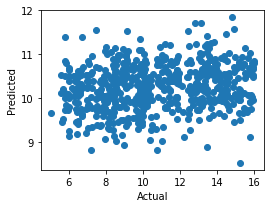

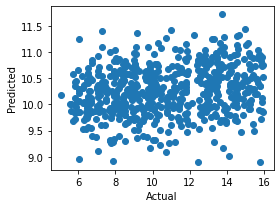

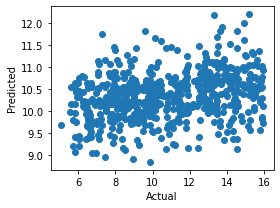

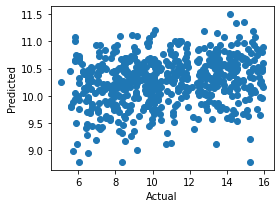

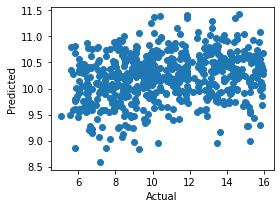

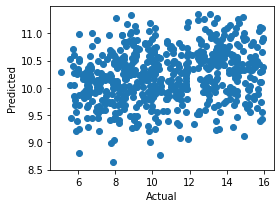

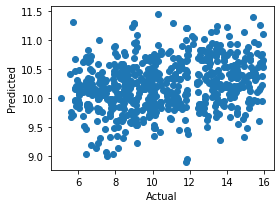

In [22]:
# include all data from both movies.
dataset = 'emo'

for emo in ['positive','negative']:
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
    out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')
    svc.plot_consistency()
    
for emo in ['anger','excite','fear','happy','sad']:
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
    out_folder = out_dir+'specific_data-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')
    svc.plot_consistency()

In [ ]:
# include all data from both movies separately for each network.
dataset = 'emo'
for net in network_names:
    for emo in ['positive','negative']:
        X_train = full_train[full_train_labels['cond']==emo][:, network_labels==net]
        Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:, network_labels==net]
        Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
        out_folder = out_dir+'general_data-{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)

    for emo in ['anger','excite','fear','happy','sad']:
        X_train = full_train[full_train_labels['cond']==emo][:, network_labels==net]
        Y_train = full_train_labels['age'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:, network_labels==net]
        Y_test =full_test_labels['age'][full_test_labels['cond']==emo]
        out_folder = out_dir+'specific_data-{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)

In [ ]:
# run separately for each movie
for mov in ['DM','TP']:

    dataset = 'emo-movie{0}'.format(mov)

    for emo in ['positive','negative']:
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

    for emo in ['anger','excite','fear','happy','sad']:
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'specific_data-{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Negative control: predict from bright/loud activation

In [ ]:
# include all data from both movies.
dataset = 'lowlevel'

for emo in ['brightness','loudness']:
    #set specific variables
    X_train = full_train[(full_train_labels['cond']==emo)]
    Y_train = full_train_labels['age'][(full_train_labels['cond']==emo)]
    groups = full_train_labels['sub'][(full_train_labels['cond']==emo)]
    X_test = full_test[(full_test_labels['cond']==emo)]
    Y_test =full_test_labels['age'][(full_test_labels['cond']==emo)]
    out_folder = out_dir+'all_data-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# test each movie separately

for mov in ['DM','TP']:

    dataset = 'lowlevel-movie{0}'.format(mov)

    for emo in ['brightness','loudness']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'all_data-{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Positive control: predict from face/word activation

In [ ]:
# include all data from both movies
dataset = 'nonemo'

for cond in ['speaking','whole_words']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==cond]
    Y_train = full_train_labels['age'][full_train_labels['cond']==cond]
    groups = full_train_labels['sub'][full_train_labels['cond']==cond]
    X_test = full_test[full_test_labels['cond']==cond]
    Y_test =full_test_labels['age'][full_test_labels['cond']==cond]
    out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, cond)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# run separately for each movie

for mov in ['DM','TP']:
    dataset = 'nonemo-movie{0}'.format(mov)

    for cond in ['speaking','whole_words']:
        #set specific variables
        X_train = full_train[(full_train_labels['cond']==cond) & (full_train_labels['movie']==mov)]
        Y_train = full_train_labels['age'][(full_train_labels['cond']==cond) & (full_train_labels['movie']==mov)]
        groups = full_train_labels['sub'][(full_train_labels['cond']==cond) & (full_train_labels['movie']==mov)]
        X_test = full_test[(full_test_labels['cond']==cond) & (full_test_labels['movie']==mov)]
        Y_test =full_test_labels['age'][(full_test_labels['cond']==cond) & (full_test_labels['movie']==mov)]
        out_folder = out_dir+'general_data-{0}_{1}/'.format(dataset, cond)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

## Analysis 2-1: SVR predicting pubertal status from activation - linear kernel

### Limit data and set model params

In [23]:
## model parameters
folds = 10
cv = GroupKFold(n_splits=folds)
random_state = 42
model = SVR(kernel='linear')

out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/linear/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)

pubdata=data[np.isfinite(data_labels['PPS_score'])]
pubdata_labels=data_labels[np.isfinite(data_labels['PPS_score'])]

# split training and testing data by site
full_train = pubdata[pubdata_labels['site']=='rubic']
full_train_labels = pubdata_labels[pubdata_labels['site']=='rubic']
full_test = pubdata[pubdata_labels['site']=='cbic']
full_test_labels = pubdata_labels[pubdata_labels['site']=='cbic']

# print labels description
pubdata_labels.describe()

,age,female,meanFD,righthanded,PPS_score
count,12350.000000,12350.000000,12350.000000,12350.000000,12350.000000
mean,10.709146,0.390526,0.341748,0.736842,9.721316
std,2.810560,0.487888,0.192134,0.440365,4.207311
min,5.055213,0.000000,0.054385,0.000000,5.000000
25%,8.532740,0.000000,0.189808,0.000000,6.000000
50%,10.584360,0.000000,0.287871,1.000000,9.000000
75%,13.093429,1.000000,0.464797,1.000000,13.000000
max,15.987451,1.000000,1.577352,1.000000,20.000000


In [ ]:
# include all data from both movies.
dataset = 'emo'

for emo in ['positive','negative']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
    out_folder = out_dir+'general_data-puberty_{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

for emo in ['anger','happy','sad','excite','fear']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
    out_folder = out_dir+'specific_data-puberty_{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# include all data from both movies separately for each network.
dataset = 'emo'

for net in network_names:
    for emo in ['positive','negative']:
        #set specific variables
        X_train = full_train[full_train_labels['cond']==emo][:,network_labels==net]
        Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:,network_labels==net]
        Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
        out_folder = out_dir+'general_data-puberty_{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)

    for emo in ['anger','happy','sad','excite','fear']:
        #set specific variables
        X_train = full_train[full_train_labels['cond']==emo][:,network_labels==net]
        Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:,network_labels==net]
        Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
        out_folder = out_dir+'specific_data-puberty_{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)

In [ ]:
# run separately for each movie
for mov in ['DM','TP']:
    dataset = 'emo-movie{0}'.format(mov)

    for emo in ['positive','negative']:
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'general_data-puberty_{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

    for emo in ['anger','happy','sad','excite','fear']:
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'specific_data-puberty_{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')


### Negative control: predict from bright/loud activation

In [ ]:
# include all data from both movies.
dataset = 'lowlevel'

for emo in ['brightness','loudness']:
    #set specific variables
    X_train = full_train[(full_train_labels['cond']==emo)]
    Y_train = full_train_labels['PPS_score'][(full_train_labels['cond']==emo)]
    groups = full_train_labels['sub'][(full_train_labels['cond']==emo)]
    X_test = full_test[(full_test_labels['cond']==emo)]
    Y_test =full_test_labels['PPS_score'][(full_test_labels['cond']==emo)]
    out_folder = out_dir+'all_data-pred_puberty-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# run separately for each movie
dataset = 'lowlevel'

for mov in ['DM','TP']:
    for emo in ['brightness','loudness']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'all_data-pred_puberty-{0}-movie{1}_{2}/'.format(dataset, mov, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Positive control: predict from face/word activation

In [ ]:
# include all data from both movies
dataset = 'nonemo'

for cond in ['speaking','whole_words']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==cond]
    Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==cond]
    groups = full_train_labels['sub'][full_train_labels['cond']==cond]
    X_test = full_test[full_test_labels['cond']==cond]
    Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==cond]
    out_folder = out_dir+'general_data-pred_puberty-{0}_{1}/'.format(dataset, cond)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# include all data from both movies
dataset = 'nonemo'

for mov in ['DM','TP']:
    for cond in ['speaking','whole_words']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==cond)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==cond)]
        out_folder = out_dir+'general_data-pred_puberty-{0}-movie{1}_{2}/'.format(dataset, mov, cond)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

## Analysis 2-2: SVR predicting pubertal status from activation - nonlinear kernel

### Load data and set model params

In [24]:
## model parameters
folds = 10
cv = GroupKFold(n_splits=folds)
random_state = 42
model = SVR(kernel='rbf')

out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/nonlinear/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)

pubdata=data[np.isfinite(data_labels['PPS_score'])]
pubdata_labels=data_labels[np.isfinite(data_labels['PPS_score'])]

# split training and testing data by site
full_train = pubdata[pubdata_labels['site']=='rubic']
full_train_labels = pubdata_labels[pubdata_labels['site']=='rubic']
full_test = pubdata[pubdata_labels['site']=='cbic']
full_test_labels = pubdata_labels[pubdata_labels['site']=='cbic']

# print labels description
pubdata_labels.describe()

,age,female,meanFD,righthanded,PPS_score
count,12350.000000,12350.000000,12350.000000,12350.000000,12350.000000
mean,10.709146,0.390526,0.341748,0.736842,9.721316
std,2.810560,0.487888,0.192134,0.440365,4.207311
min,5.055213,0.000000,0.054385,0.000000,5.000000
25%,8.532740,0.000000,0.189808,0.000000,6.000000
50%,10.584360,0.000000,0.287871,1.000000,9.000000
75%,13.093429,1.000000,0.464797,1.000000,13.000000
max,15.987451,1.000000,1.577352,1.000000,20.000000


In [16]:
# include all data from both movies.
dataset = 'emo'

for emo in ['positive','negative']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
    out_folder = out_dir+'general_data-puberty_{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')
    
for emo in ['anger','happy','fear','sad','excite']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==emo]
    Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
    groups = full_train_labels['sub'][full_train_labels['cond']==emo]
    X_test = full_test[full_test_labels['cond']==emo]
    Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
    out_folder = out_dir+'specific_data-puberty_{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# include all data from both movies.
dataset = 'emo'

for net in network_names:

    for emo in ['positive','negative']:
        #set specific variables
        X_train = full_train[full_train_labels['cond']==emo][:,network_labels==net]
        Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:,network_labels==net]
        Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
        out_folder = out_dir+'general_data-puberty_{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)

    for emo in ['anger','happy','fear','sad','excite']:
        #set specific variables
        X_train = full_train[full_train_labels['cond']==emo][:,network_labels==net]
        Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==emo]
        groups = full_train_labels['sub'][full_train_labels['cond']==emo]
        X_test = full_test[full_test_labels['cond']==emo][:,network_labels==net]
        Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==emo]
        out_folder = out_dir+'specific_data-puberty_{0}_{1}/{2}/'.format(dataset, emo, net)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)

In [ ]:
# run separately for each movie

for mov in ['DM','TP']:
    
    dataset = 'emo-movie{0}'.format(mov)

    for emo in ['positive','negative']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'general_data-puberty_{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

    for emo in ['anger','happy','fear','sad','excite']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'specific_data-puberty_{0}_{1}/'.format(dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Negative control: predict from bright/loud activation

In [25]:
# include all data from both movies.
dataset = 'lowlevel'

for emo in ['brightness','loudness']:
    #set specific variables
    X_train = full_train[(full_train_labels['cond']==emo)]
    Y_train = full_train_labels['PPS_score'][(full_train_labels['cond']==emo)]
    groups = full_train_labels['sub'][(full_train_labels['cond']==emo)]
    X_test = full_test[(full_test_labels['cond']==emo)]
    Y_test =full_test_labels['PPS_score'][(full_test_labels['cond']==emo)]
    out_folder = out_dir+'all_data-pred_puberty-{0}_{1}/'.format(dataset, emo)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# run separately for each movie
dataset = 'lowlevel'

for mov in ['DM','TP']:
    for emo in ['brightness','loudness']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'all_data-pred_puberty-{0}-movie{1}_{2}/'.format(dataset, mov, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

### Positive control: predict from face/word activation

In [26]:
# include all data from both movies
dataset = 'nonemo'

for cond in ['speaking','whole_words']:
    #set specific variables
    X_train = full_train[full_train_labels['cond']==cond]
    Y_train = full_train_labels['PPS_score'][full_train_labels['cond']==cond]
    groups = full_train_labels['sub'][full_train_labels['cond']==cond]
    X_test = full_test[full_test_labels['cond']==cond]
    Y_test =full_test_labels['PPS_score'][full_test_labels['cond']==cond]
    out_folder = out_dir+'general_data-pred_puberty-{0}_{1}/'.format(dataset, cond)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups, kernel='poly')
    svc = svc.predict(X_test, Y_test, kind='regress')
    #svc.boot_predict(kind='regress', ci=95)
    svc.calc_permuted_pvalue(kind='regress')

In [ ]:
# include all data from both movies
dataset = 'nonemo'

for mov in ['DM','TP']:
    for cond in ['speaking','whole_words']:
        #set specific variables
        X_train = full_train[(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        Y_train = full_train_labels['PPS_score'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & (full_train_labels['cond']==cond)]
        X_test = full_test[(full_test_labels['movie']==mov) & (full_test_labels['cond']==cond)]
        Y_test =full_test_labels['PPS_score'][(full_test_labels['movie']==mov) & (full_test_labels['cond']==cond)]
        out_folder = out_dir+'general_data-pred_puberty-{0}-movie{1}_{2}/'.format(dataset, mov, cond)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups, kernel='poly')
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.boot_predict(kind='regress', ci=95)
        svc.calc_permuted_pvalue(kind='regress')

## compile results

In [28]:
for model in ['linear','nonlinear','motion']:
    results = pd.DataFrame(columns=['Network', 'data', 'emotion', 'SpearR', 'SpearR_CI' , 'SpearPval', 'PearR', 'PearR_CI','PearPval', 'LinB','LinPval','MSE','MSE_CI','TestPermPval'])
    out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/{1}/'.format(thresh, model)
    folders = os.listdir(out_dir)
    for f in folders:
        if os.path.isfile(out_dir + f + '/performance_report.csv'):
            t = pd.read_csv(out_dir + f + '/performance_report.csv', index_col=0)
            results.loc[f, 'SpearR'] = t.loc['SpearmanR', 'stat']
            results.loc[f, 'SpearPval'] = t.loc['SpearmanR', 'pval']
            results.loc[f, 'PearR'] = t.loc['PearsonR', 'stat']
            results.loc[f, 'PearPval'] = t.loc['PearsonR', 'pval']
            results.loc[f, 'LinB'] = t.loc['LinearB', 'stat']
            results.loc[f, 'LinPval'] = t.loc['LinearB', 'pval']
            results.loc[f, 'MSE'] = t.loc['MSE', 'stat']
        if os.path.isfile(out_dir + f + '/bootstrapped_test_accuracy.csv'):
            t = pd.read_csv(out_dir + f + '/bootstrapped_test_accuracy.csv', index_col=0)
            results.loc[f, 'SpearR_CI'] = '[{0}, {1}]'.format(round(t.loc['spearmanr','lowerCI'],2), round(t.loc['spearmanr','upperCI'],2))
            results.loc[f, 'PearR_CI'] = '[{0}, {1}]'.format(round(t.loc['pearsonr','lowerCI'],2), round(t.loc['pearsonr','upperCI'],2))
            results.loc[f, 'MSE_CI'] = '[{0}, {1}]'.format(round(t.loc['test_scores','lowerCI'],1), round(t.loc['test_scores','upperCI'],1))
        if os.path.isfile(out_dir + f + '/bootstrapped_test_accuracy_randN.csv'):
            t = pd.read_csv(out_dir + f + '/bootstrapped_test_accuracy_randN.csv', index_col=0)
            results.loc[f, 'SpearR_CI'] = '[{0}, {1}]'.format(round(t.loc['spearmanr','lowerCI'],2), round(t.loc['spearmanr','upperCI'],2))
            results.loc[f, 'PearR_CI'] = '[{0}, {1}]'.format(round(t.loc['pearsonr','lowerCI'],2), round(t.loc['pearsonr','upperCI'],2))
            results.loc[f, 'MSE_CI'] = '[{0}, {1}]'.format(round(t.loc['test_scores','lowerCI'],1), round(t.loc['test_scores','upperCI'],1))
        if os.path.isfile(out_dir + f + '/permutation_stats.csv'):
            t = pd.read_csv(out_dir + f + '/permutation_stats.csv', index_col=0)
            results.loc[f, 'TestPermPval'] = t.loc['Test_Score','PermPval']
     
    for d in ['puberty_emo','emo']:
        for c in ['anger','happy','sad','fear','excite']:
            for net in network_labels:
                f = '{0}-{1}_{2}'.format(d, c, net)
                results.loc[f, 'Network'] = net
                results.loc[f, 'emotion'] = c
                results.loc[f, 'data'] = 'o_' + d
                if os.path.isfile('{0}specific_data-{3}_{1}/{2}/performance_report.csv'.format(out_dir, c, net, d)):
                    t = pd.read_csv('{0}specific_data-{3}_{1}/{2}/performance_report.csv'.format(out_dir, c, net, d), index_col=0)
                    results.loc[f, 'SpearR'] = t.loc['SpearmanR', 'stat']
                    results.loc[f, 'SpearPval'] = t.loc['SpearmanR', 'pval']
                    results.loc[f, 'PearR'] = t.loc['PearsonR', 'stat']
                    results.loc[f, 'PearPval'] = t.loc['PearsonR', 'pval']
                    results.loc[f, 'LinB'] = t.loc['LinearB', 'stat']
                    results.loc[f, 'LinPval'] = t.loc['LinearB', 'pval']
                    results.loc[f, 'MSE'] = t.loc['MSE', 'stat']
                if os.path.isfile('{0}specific_data-{3}_{1}/{2}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, c, net, d)):
                    t = pd.read_csv('{0}specific_data-{3}_{1}/{2}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, c, net, d), index_col=0)
                    results.loc[f, 'SpearR_CI'] = '[{0}, {1}]'.format(round(t.loc['spearmanr','lowerCI'],2), round(t.loc['spearmanr','upperCI'],2))
                    results.loc[f, 'PearR_CI'] = '[{0}, {1}]'.format(round(t.loc['pearsonr','lowerCI'],2), round(t.loc['pearsonr','upperCI'],2))
                    results.loc[f, 'MSE_CI'] = '[{0}, {1}]'.format(round(t.loc['test_scores','lowerCI'],1), round(t.loc['test_scores','upperCI'],1))

        for c in ['positive', 'negative']:
            for net in network_labels:
                f = '{0}-{1}_{2}'.format(d, c, net)
                results.loc[f, 'Network'] = net
                results.loc[f, 'emotion'] = c
                results.loc[f, 'data'] = 'o_' + d
                if os.path.isfile('{0}general_data-{3}_{1}/{2}/performance_report.csv'.format(out_dir, c, net, d)):
                    t = pd.read_csv('{0}general_data-{3}_{1}/{2}/performance_report.csv'.format(out_dir, c, net, d), index_col=0)
                    results.loc[f, 'SpearR'] = t.loc['SpearmanR', 'stat']
                    results.loc[f, 'SpearPval'] = t.loc['SpearmanR', 'pval']
                    results.loc[f, 'PearR'] = t.loc['PearsonR', 'stat']
                    results.loc[f, 'PearPval'] = t.loc['PearsonR', 'pval']
                    results.loc[f, 'LinB'] = t.loc['LinearB', 'stat']
                    results.loc[f, 'LinPval'] = t.loc['LinearB', 'pval']
                    results.loc[f, 'MSE'] = t.loc['MSE', 'stat']
                if os.path.isfile('{0}general_data-{3}_{1}/{2}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, c, net, d)):
                    t = pd.read_csv('{0}general_data-{3}_{1}/{2}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, c, net, d), index_col=0)
                    results.loc[f, 'SpearR_CI'] = '[{0}, {1}]'.format(round(t.loc['spearmanr','lowerCI'],2), round(t.loc['spearmanr','upperCI'],2))
                    results.loc[f, 'PearR_CI'] = '[{0}, {1}]'.format(round(t.loc['pearsonr','lowerCI'],2), round(t.loc['pearsonr','upperCI'],2))
                    results.loc[f, 'MSE_CI'] = '[{0}, {1}]'.format(round(t.loc['test_scores','lowerCI'],1), round(t.loc['test_scores','upperCI'],1))
            
    results.to_csv(out_dir + '{0}_results.csv'.format(model))  

### Plot results

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='talk', style='white')

model = 'linear'
out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/{1}/'.format(thresh, model)
results = pd.read_csv(out_dir + '{0}_results.csv'.format(model), index_col=0)
results[:10]

,Network,data,emotion,SpearR,SpearR_CI,SpearPval,PearR,PearR_CI,PearPval,LinB,LinPval,MSE,MSE_CI,TestPermPval
general_data-puberty_emo-movieTP_positive,NaN,NaN,NaN,0.095659,"[-0.02, 0.2]",1.481329e-01,0.102539,"[-0.02, 0.2]",1.209737e-01,0.146082,1.209737e-01,23.948895,"[21.3, 28.9]",0.488151
specific_data-puberty_emo_happy,NaN,NaN,NaN,0.156906,"[0.07, 0.23]",1.238326e-03,0.154881,"[0.07, 0.23]",1.434113e-03,0.301087,1.434113e-03,22.228273,"[20.2, 25.3]",0.486751
general_data-pred_puberty-nonemo-movieTP_speaking,NaN,NaN,NaN,-0.019286,"[-0.15, 0.11]",7.711170e-01,0.046849,"[-0.1, 0.17]",4.795577e-01,0.077186,4.795577e-01,23.365861,"[21.2, 29.0]",0.379862
specific_data-emo-movieTP_excite,NaN,NaN,NaN,0.158960,"[0.05, 0.24]",3.953688e-03,0.152307,"[0.04, 0.23]",5.784503e-03,0.222891,5.784503e-03,9.942353,"[9.4, 12.3]",0.249575
specific_data-emo-movieDM_excite,NaN,NaN,NaN,0.411713,"[0.29, 0.48]",5.796086e-13,0.393668,"[0.28, 0.47]",6.864586e-12,0.677454,6.864586e-12,8.284627,"[7.4, 9.9]",0.339966
general_data-nonemo_speaking,NaN,NaN,NaN,0.106038,"[0.03, 0.17]",8.823724e-03,0.114257,"[0.04, 0.17]",4.756364e-03,0.150794,4.756364e-03,12.264248,"[11.8, 14.1]",0.788121
specific_data-puberty_emo-movieDM_anger,NaN,NaN,NaN,0.347142,"[0.21, 0.44]",8.655988e-07,0.308147,"[0.18, 0.41]",1.446246e-05,0.673615,1.446246e-05,19.034845,"[16.1, 22.9]",0.384562
specific_data-emo-movieDM_happy,NaN,NaN,NaN,0.236428,"[0.13, 0.33]",6.080746e-05,0.231062,"[0.13, 0.32]",9.000220e-05,0.456391,9.000220e-05,9.445317,"[8.4, 10.9]",0.653935
general_data-puberty_emo-movieDM_negative,NaN,NaN,NaN,0.209466,"[0.07, 0.32]",3.635127e-03,0.214106,"[0.09, 0.31]",2.938066e-03,0.502228,2.938066e-03,21.702391,"[18.4, 25.8]",0.519848
general_data-emo_negative,NaN,NaN,NaN,0.163559,"[0.07, 0.23]",5.005922e-05,0.166282,"[0.08, 0.23]",3.726464e-05,0.301618,3.726464e-05,9.496716,"[9.1, 10.8]",0.364264


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


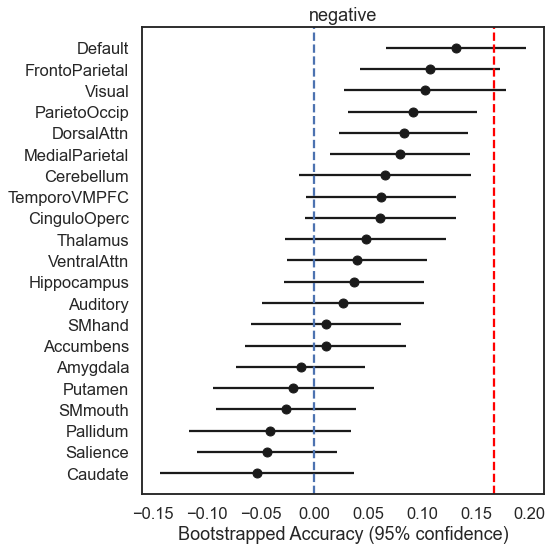

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


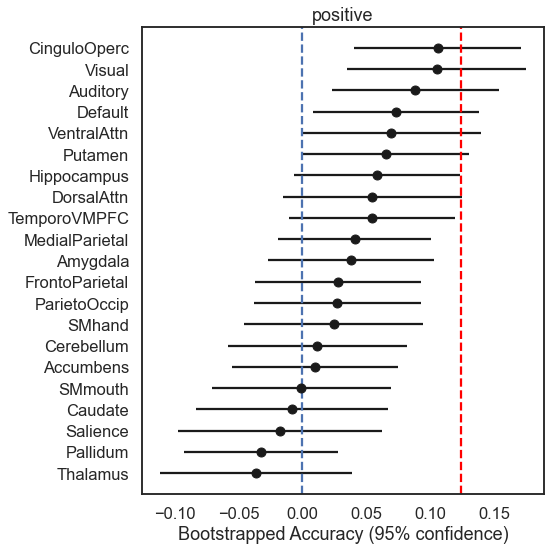

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


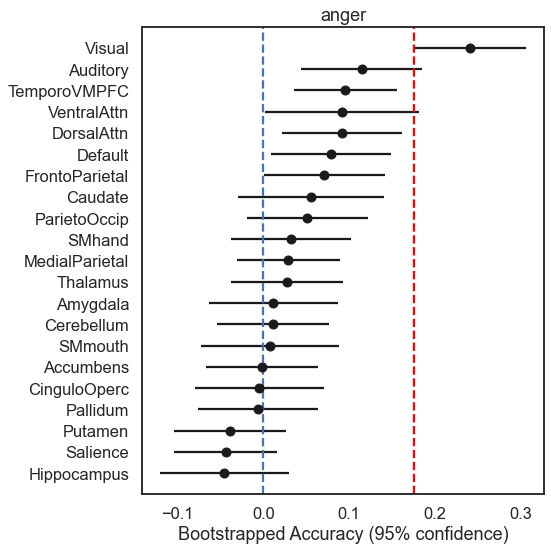

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


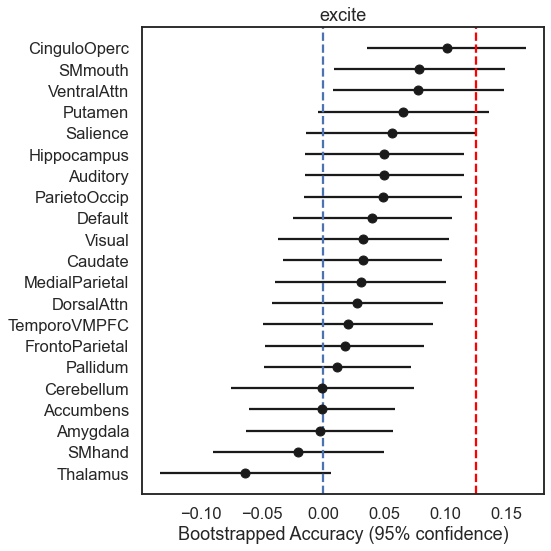

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


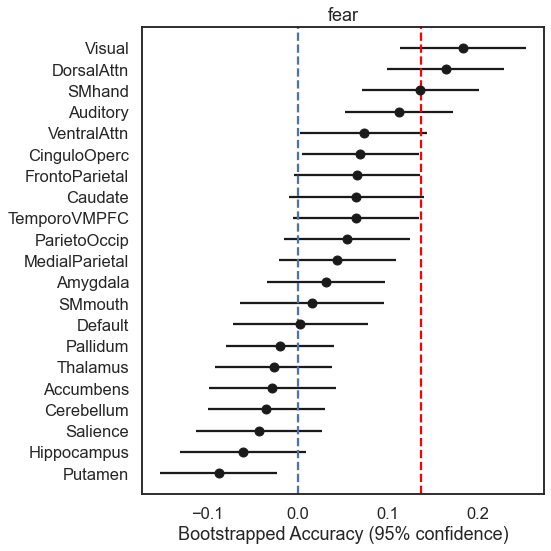

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


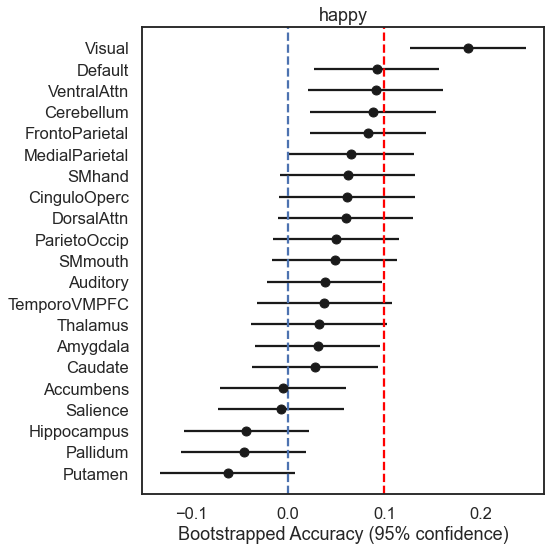

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_22776/1568690962.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2


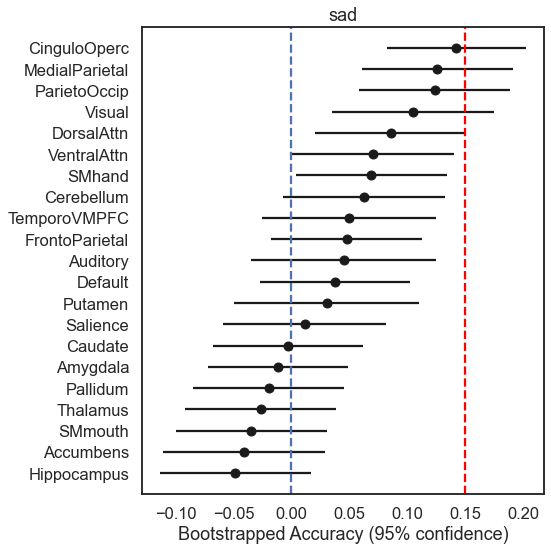

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='talk', style='white')

model = 'linear'
out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/{1}/'.format(thresh, model)
os.makedirs(out_dir + '_figures', exist_ok=True)

results = pd.read_csv(out_dir + '{0}_results.csv'.format(model), index_col=0)
kind = ['general','general','specific','specific','specific','specific','specific']

for i, e in enumerate(['negative', 'positive','anger','excite','fear','happy','sad']): 
    gennet = results.loc[(results['emotion']==e) & (results['data'].str.contains('o_emo')),:]
    a = gennet['PearR_CI'].str.strip('[]').str.split(',', expand=True)
    gennet.loc[:,'PearTestLower'] = a[0].astype(float)
    gennet.loc[:,'PearTestUpper'] = a[1].astype(float)
    gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2
    gennet = gennet.sort_values('PearR', ascending=True)
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.errorbar(x=gennet['PearR'], y=range(len(gennet['PearR'])), xerr=gennet['PearTestBootError'], fmt='o', color='k')
    plt.axvline(0, ls='--')
    plt.axvline(results.loc['{0}_data-emo_{1}'.format(kind[i], e),'PearR'], ls='--', color='red')
    ax.set_yticks(range(0,len(gennet['Network'])))
    ax.set_yticklabels(gennet['Network'].replace('None','TemporoVMPFC'))
    ax.set_xlabel('Bootstrapped Accuracy (95% confidence)')
    ax.set_title(e)
    plt.tight_layout()
    plt.savefig(out_dir + '_figures/{0}_bootstap_accuracy.svg'.format(e))
    plt.show()
    plt.close()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='talk', style='white')

model = 'nonlinear'
out_dir = project_dir + 'SVM_results/thresh{0}/age_analysis/{1}/'.format(thresh, model)
results = pd.read_csv(out_dir + '{0}_results.csv'.format(model), index_col=0)

for i, e in enumerate(['negative', 'positive','anger','excite','fear','happy','sad']): 
    gennet = results.loc[(results['emotion']==e) & (results['data'].str.contains('o_emo')),:]
    a = gennet['PearR_CI'].str.strip('[]').str.split(',', expand=True)
    gennet.loc[:,'PearTestLower'] = a[0].astype(float)
    gennet.loc[:,'PearTestUpper'] = a[1].astype(float)
    gennet['PearTestBootError'] = (gennet['PearTestUpper'] - gennet['PearTestLower'])/2
    gennet = gennet.sort_values('PearR', ascending=True)
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.errorbar(x=gennet['PearR'], y=range(len(gennet['PearR'])), xerr=gennet['PearTestBootError'], fmt='o', color='k')
    plt.axvline(0, ls='--')
    plt.axvline(full_model_acc[i], ls='--', color='red')
    ax.set_yticks(range(0,len(gennet['Network'])))
    ax.set_yticklabels(gennet['Network'].replace('None','TemporoVMPFC'))
    ax.set_xlabel('Bootstrapped Accuracy (95% confidence)')
    ax.set_title(e)
    plt.tight_layout()
    plt.savefig(out_dir + '_figures/{0}_bootstap_accuracy.svg'.format(e))
    plt.show()
    plt.close()